# Mini-Projet: Rechauffement Climatique:

## Introduction:

Dans ce mini-projet on cherche à détecter un effet de réchauffement climatique à partir des données de la station météorologique de Montélimar. Ces données sont composées de dates et leurs températures correspondantes, depuis juin 1920 jusqu'à fin 2019. On ajustera les données selon des modèles proposés avec deux méthodes différentes, qui supposeront toutes les deux un accroissement linéaire de la température au cours du temps. Dans un premier temps, on importera les données et on convertira les dates en MJD (Modified Julian Day) en format _datetime_ qui facilitera la trace des données. Dans la suit on supposera une incertitude de $5 ^{\circ} C$ car c'est du même ordre que les fluctuations quotidiennes de température.

### Initialisation et import des données et modules requis:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as sc
import pandas as pd
import fitutils as fu
import os

imsize=300
plt.style.use("dark_background")
data = np.loadtxt("montelimar_temperature.dat", unpack=True)

jd_dates = data[0,:] + 2400000.5
dates = np.array(pd.to_datetime(jd_dates, unit ="D", origin="julian"))

## Méthode 1: 

La première méthode consiste à faire un ajustement sur les données selon la fonction $ T(t) = A \sin{(\omega t + \phi)} + B $ où les paramètres $A$ (amplitude), $\phi$ (phase) et $B$ (température moyenne) seront ajustés aux données pour chaque décennie afin d'effectuer une analyse de l'évolution de la température sur une échelle de temps plus large que les fluctuations quotidiennes et saisonnières (sauf $\omega = 2\pi/1\text{ an}$). La division des données en sous-ensembles permettra d'appliquer le modèle sur chaque décennie afin d'estimer l'évolution de la température au fil des décennies. En ajustant les paramètres du modèle pour chaque décennie, on peut étudier l'accroissement lent de la température et voir si le paramètre $B$ augmente d'une manière significative.

### Division en décennies et ajustement:

In [2]:
def T_bydecade(x, a, b, omega, phi):
    return a * np.sin(omega * x + phi) + b

num_days_per_decade = 3652
num_decades = int((data[0,-1] - data[0,0])//num_days_per_decade+1)
data_bydecade = np.zeros(( num_decades+1, 2 , num_days_per_decade ))
x_bydecade = np.zeros(( num_decades, num_days_per_decade ))
y_bydecade = np.zeros(( num_decades, num_days_per_decade ))
decadetitles = []

for j in range(num_decades):
    decadetitles.append(f"Décennie {j+1}")
    for k in range(2):
        for i in range(num_days_per_decade):
            if j<num_decades-1:
                data_bydecade[j, k, i] = data[k, j * num_days_per_decade + i]
            else:
                data_bydecade[j, :, :3427] = data[:, num_days_per_decade * j:]

data_bydecade[9,:,:3427] = data[:,num_days_per_decade*9:]
x_bydecade = data_bydecade[:, 0, :]
y_bydecade = data_bydecade[:, 1, :]
error_bydecade = 5*np.ones_like(y_bydecade)
p0_bydecade = [20, 15,  2*np.pi/365, np.pi]
params_bydecade = np.zeros((num_decades, 4))
pcov_bydecade = np.zeros((num_decades,4,4))
perr_bydecade = np.zeros((num_decades,len(p0_bydecade)))
dates_bydecade = np.append( dates, pd.to_datetime(np.zeros(225)) ).reshape(
    (num_decades,num_days_per_decade))

for i in range(num_decades):
    perr_bydecade[i,:] = np.sqrt(np.diag(pcov_bydecade[i,:]))
    x_bydecade[i,:] = x_bydecade[i,:] - i * num_days_per_decade
    params_bydecade[i,:], pcov_bydecade[i,:] = sc.curve_fit(
        T_bydecade, x_bydecade[i,:], y_bydecade[i,:], p0_bydecade, sigma=error_bydecade[i,:], absolute_sigma=True
            )
    perr_bydecade[i,:] = np.sqrt(np.diag(pcov_bydecade[i,:]))

fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(9, 16), dpi=imsize*2)

for i, ax in enumerate(axs.flat):

    formatcondition = np.where(dates_bydecade[i,:] != pd.to_datetime(np.zeros_like(dates_bydecade[i,:])))

    ax.plot( (dates_bydecade[i,:])[formatcondition] , (y_bydecade[i,:])[formatcondition],
             linewidth = 0.2, color="#AA60CC", label = "Données")

    ax.plot( (dates_bydecade[i,:])[formatcondition], (T_bydecade(x_bydecade[i,:],
                                                                    params_bydecade[i,0],
                                                                    params_bydecade[i,1],
                                                                    params_bydecade[i,2],
                                                                    params_bydecade[i,3]
                                                                                         ))[formatcondition],
        linewidth = 1, color="#60ccaa",
        label = rf"$A$, $B$, $\omega$, $\phi$ = {np.round(params_bydecade[i,:], 2)}")

    ax.grid(color="#545454")
    ax.legend(loc="lower left", fontsize="small")
    ax.tick_params(axis='x', rotation=45)
    ax.set_title(decadetitles[i])
fig.supxlabel(r"Temps ($t$/an)")
fig.supylabel(r"Température ($T$/$\degree C$)")
plt.suptitle(r"Ajustement selon $T(t) = A \sin{(\omega t + \phi)} + B$ par décennie")
plt.tight_layout()
plt.show()

On voit sur cette figure que la forme de la fonction est bien proche de celle des données. Pourtant il existe une variation importante dans les paramètres $A$ (de $8.52$ à $9.75$), $B$ (de $12.73$ à $14.35$), et $\phi$ (de $4.37$ à $3.14$) au cours du temps (min à max). Il faut donc tracer ces paramètres et y appliquer un ajustement linéaire afin d'étudier leurs comportements.

### Étude du comportement des paramètres:

On trace un graphique qui montre comment ces paramètres varient au fil du temps en fonction de décennies. Le graphique aura quatre sous-graphiques, chacun traçant la variation d'un paramètre différent en fonction de la décennie.

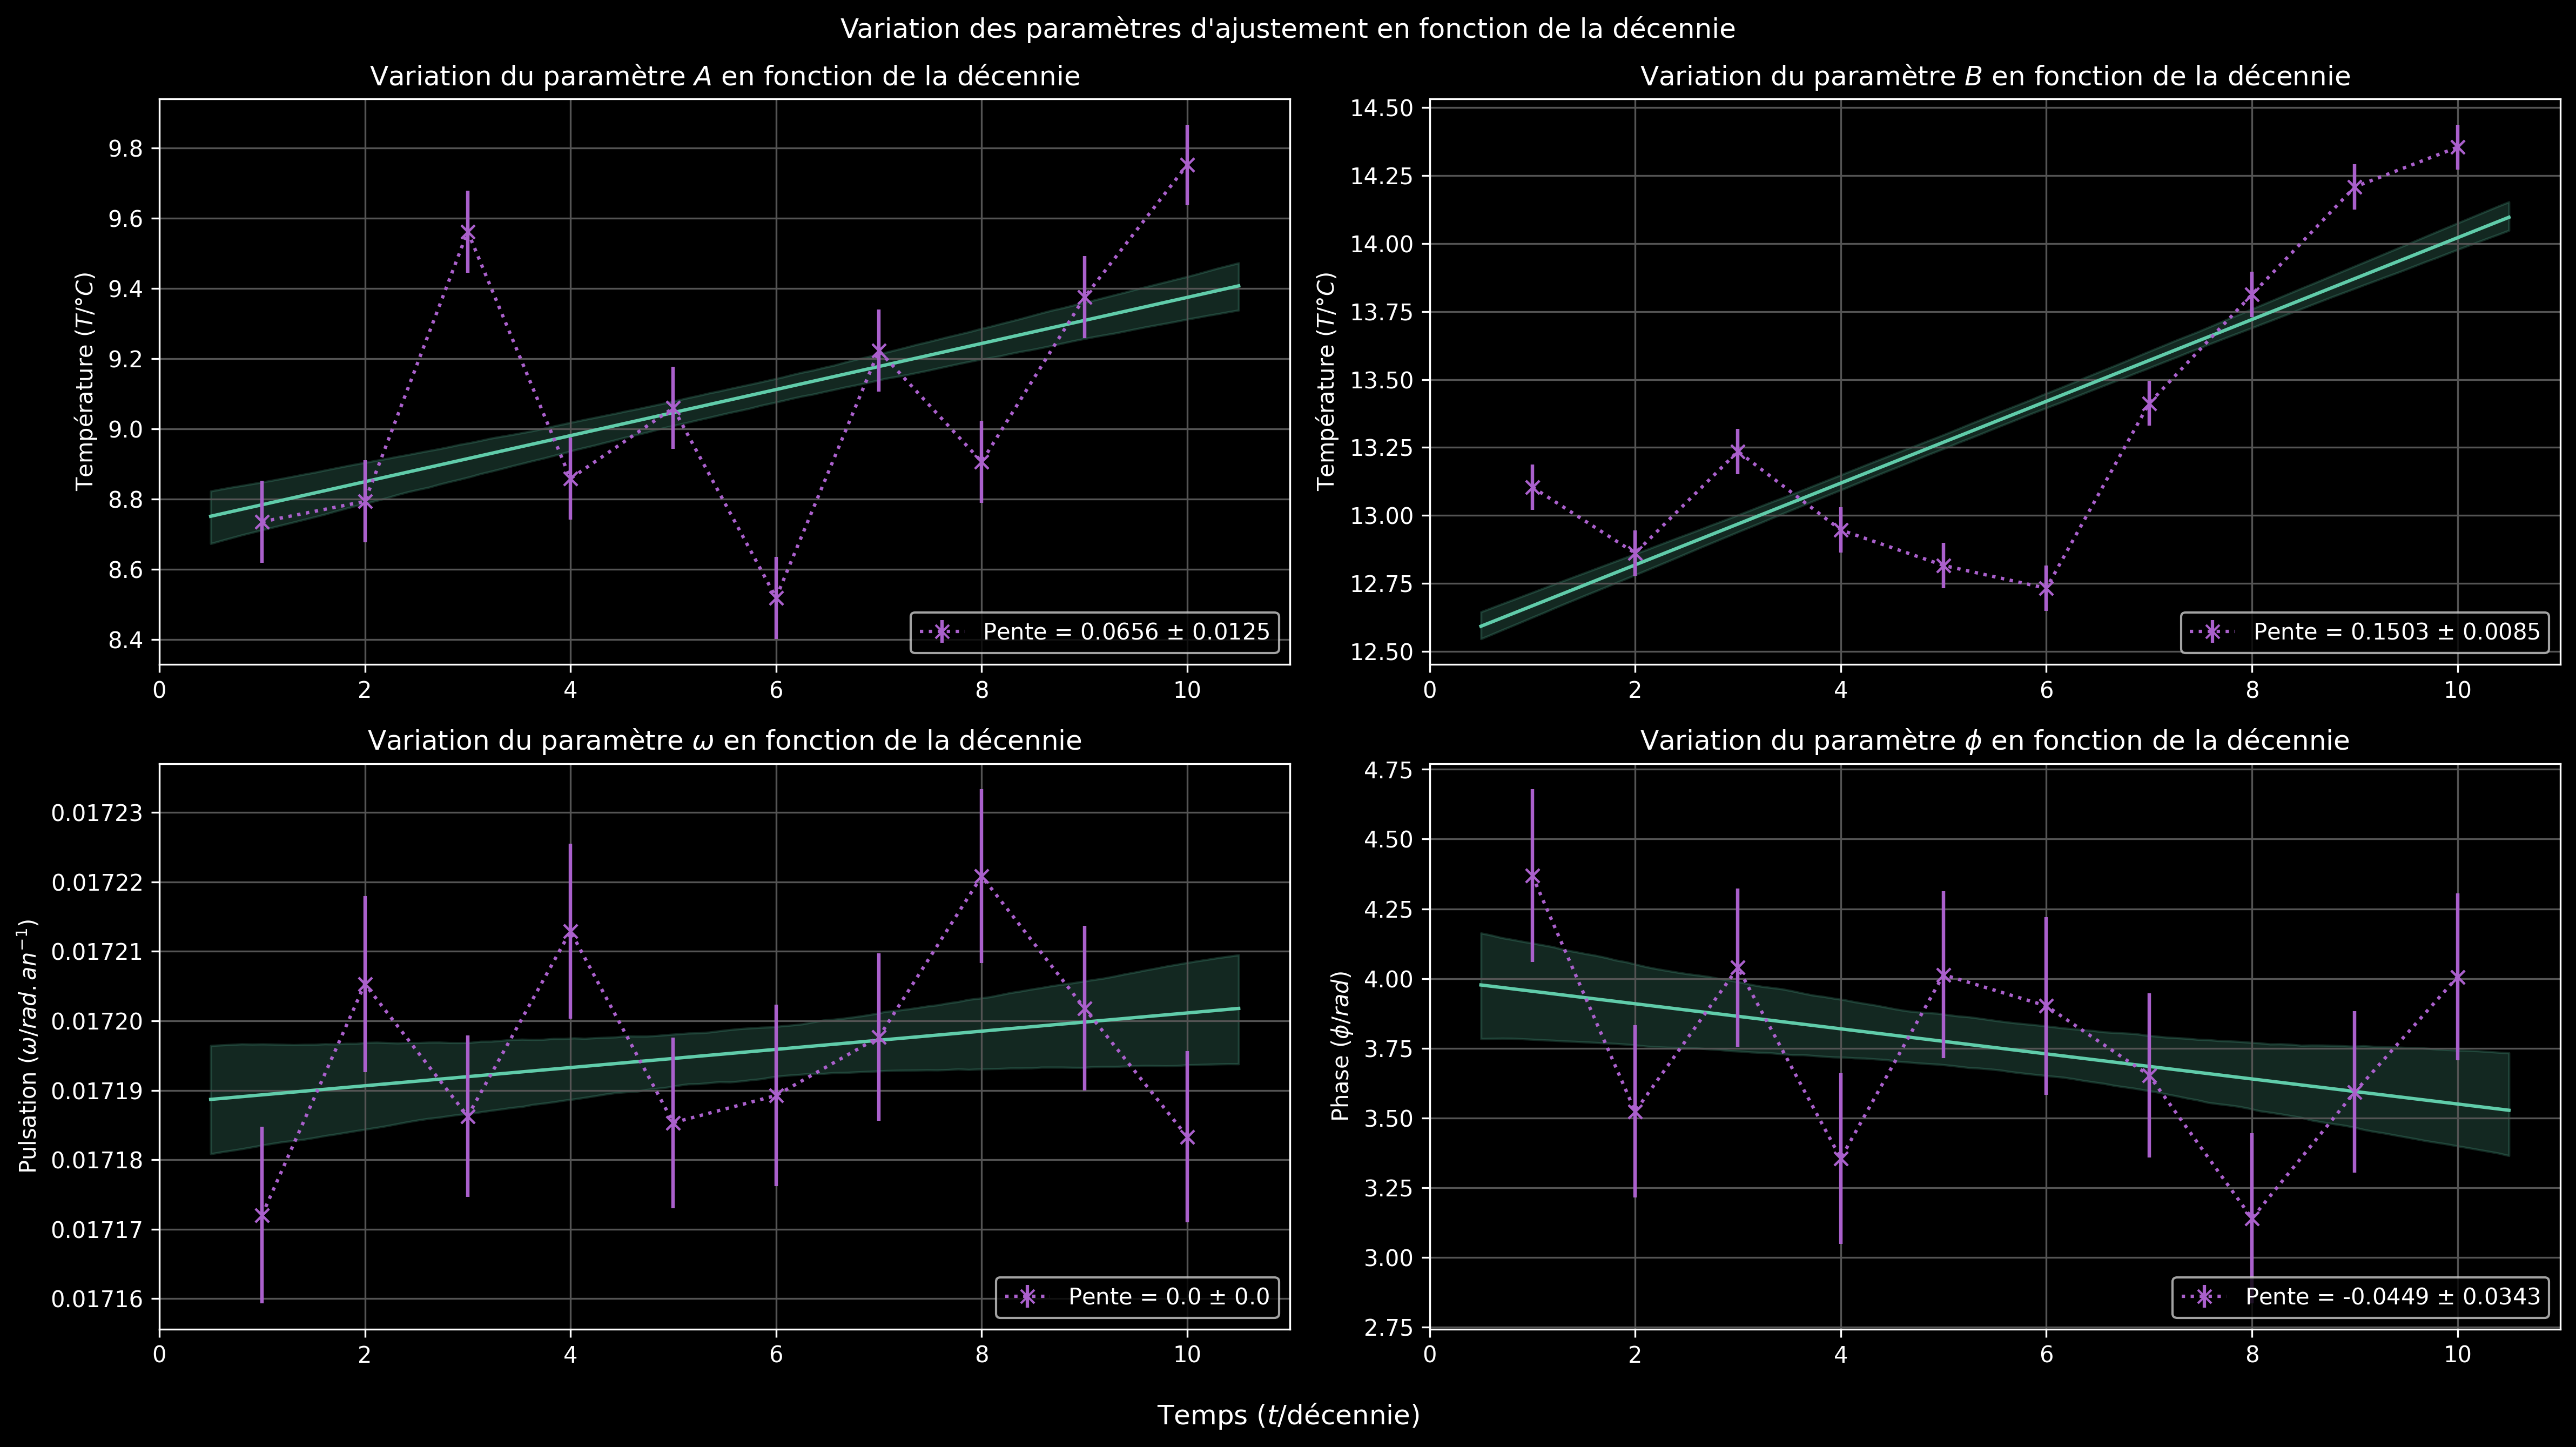

In [3]:
decadeforparams = np.arange(1, num_decades+1)
paramnamesandlabels = np.array([[r"$A$", r"$B$", r"$\omega$", r"$\phi$"],
                       [r"Température ($T$/$\degree C$)", r"Température ($T$/$\degree C$)", r"Pulsation ($\omega$/$rad.an^{-1}$)", r"Phase ($\phi$/$rad$)"]])
paramtitles_bydecade = []
res = []

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16,9), dpi=imsize)
for i, ax in enumerate(axs.flat):
    ax.set_ylabel(paramnamesandlabels[1,i])
    ax.grid(color="#545454")
    res.append(fu.linfitxy(decadeforparams, params_bydecade[:,i], dy = perr_bydecade[:,i],
                plot=True, ax=ax, linecolor="#60ccaa", markercolor="#AA60CC", marker="x"))
    ax.errorbar(decadeforparams, params_bydecade[:,i], yerr=perr_bydecade[:,i],
                marker="x", linestyle=":", color="#AA60CC", label=fr"Pente = {np.round((res[i])[0],4)} $\pm$ {np.round((res[i])[2],4)}")
    ax.set_title(f"Variation du paramètre {paramnamesandlabels[0, i]} en fonction de la décennie")
    ax.legend(loc="lower right")

fig.supxlabel(r"Temps ($t$/décennie)")
plt.suptitle("Variation des paramètres d'ajustement en fonction de la décennie")
plt.tight_layout()
plt.show()

En regardant cette figure on constate que les paramètres mentionnés ($A,B,\phi$) sont tous conformes à des fonctions linéaires. $A$ croît avec une pente de $0.064 \pm 0.0124 ^{\circ} C / \text{décennie}$. $B$ croît également avec une pente de $0.15 \pm 0.0093 ^{\circ} C / \text{décennie}$. $\phi$ décroît avec une pente de $-0.04 \pm 0.04 rad / \text{décennie}$ qui est donc trop petit par rapport à son incertitude. La variation de $\phi$ n'est pas significative. $\omega$ reste stable dans le temps.

On observe donc ici un effet de rechauffement climatique significatif d'eviron $1.5 \pm 0.09  ^{\circ}C$ depuis juin 1920.

## Méthode 2:

La méthode 2 est largement la même que la première, sauf qu'ici, on calculera la tendance sur l'ensemble de la période d'étude selon une fonction qui suppose d'avantage une croissance linéaire ($ T(t) = A \sin{(\omega t + \phi)} + Bt + C $). Dans ce cas, le paramètre $B$ devient la pente de l'accroissement linéaire de la température moyenne, et $C$ prendra le rôle de la température moyenne de départ.

### Ajustement et trace des données:

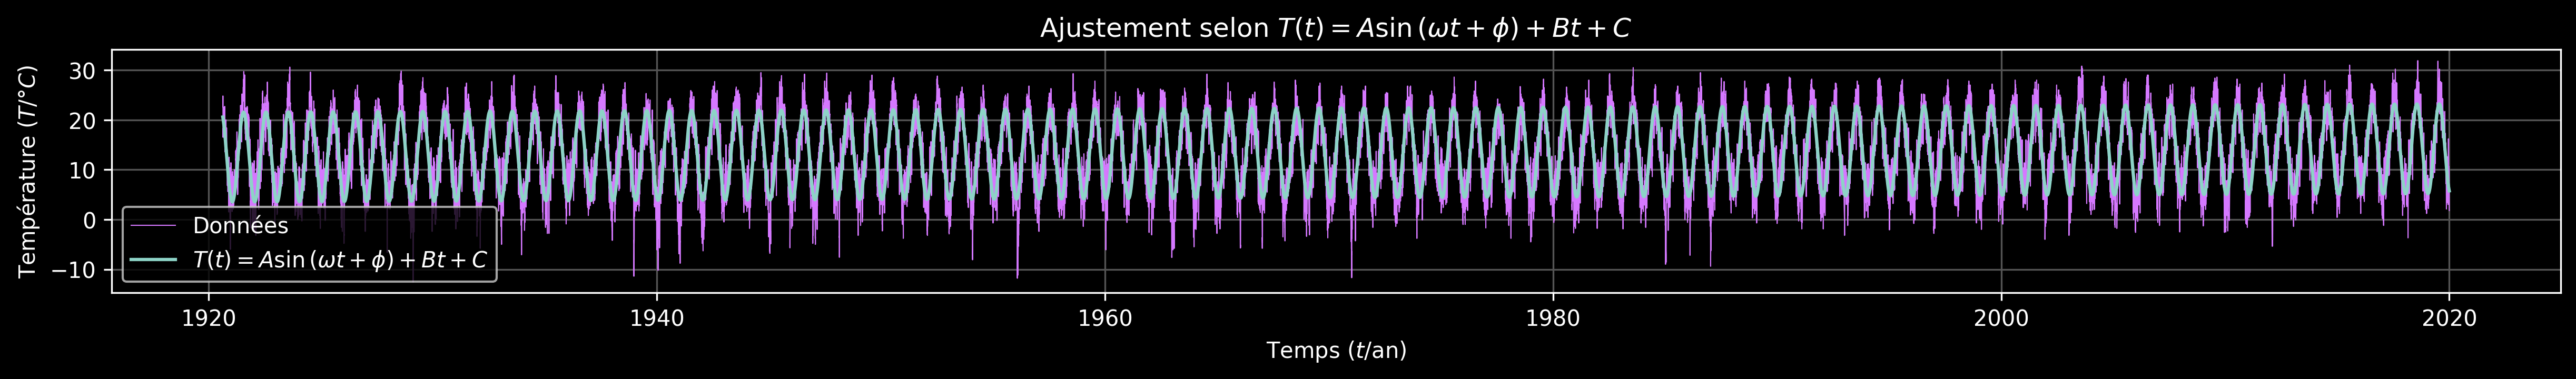

In [4]:
def T(x, a, b, c, omega, phi):
    return a * np.sin(omega * x + phi) + b * x + c

error = np.ones_like(data[1,:])
p0 = [20, 0, 15, 2*np.pi/365, np.pi]
params, pcov = sc.curve_fit(T, data[0, :], data[1, :], p0, sigma=error, absolute_sigma=True)
perr = np.sqrt(np.diag(pcov))

plt.figure(figsize=(20,2), dpi = imsize)
plt.plot(dates, data[1, :], color="#D578FF", linewidth = 0.5, label="Données")
plt.plot(dates, T(data[0, :],
    params[0], params[1], params[2], params[3], params[4]),
        label=r"$ T(t) = A \sin{(\omega t + \phi)} + Bt + C $")
plt.xlabel(r"Temps ($t$/an)")
plt.ylabel(r"Température ($T$/$\degree C$)")
plt.title(r"Ajustement selon $T(t) = A \sin{(\omega t + \phi)} + Bt + C$")
plt.grid(color="#545454")
plt.legend(loc="lower left")
plt.show()

### Extraction des termes d'accroissement:

On trace la fonction $T(t) - (A \sin{(\omega t + \phi)}) = Bt + C$ pour étudier les termes d'accroissement $B$ et $C$. L'erreur vient de l'incertitude relative du terme $B$ multipliée par la valeur de $T$.

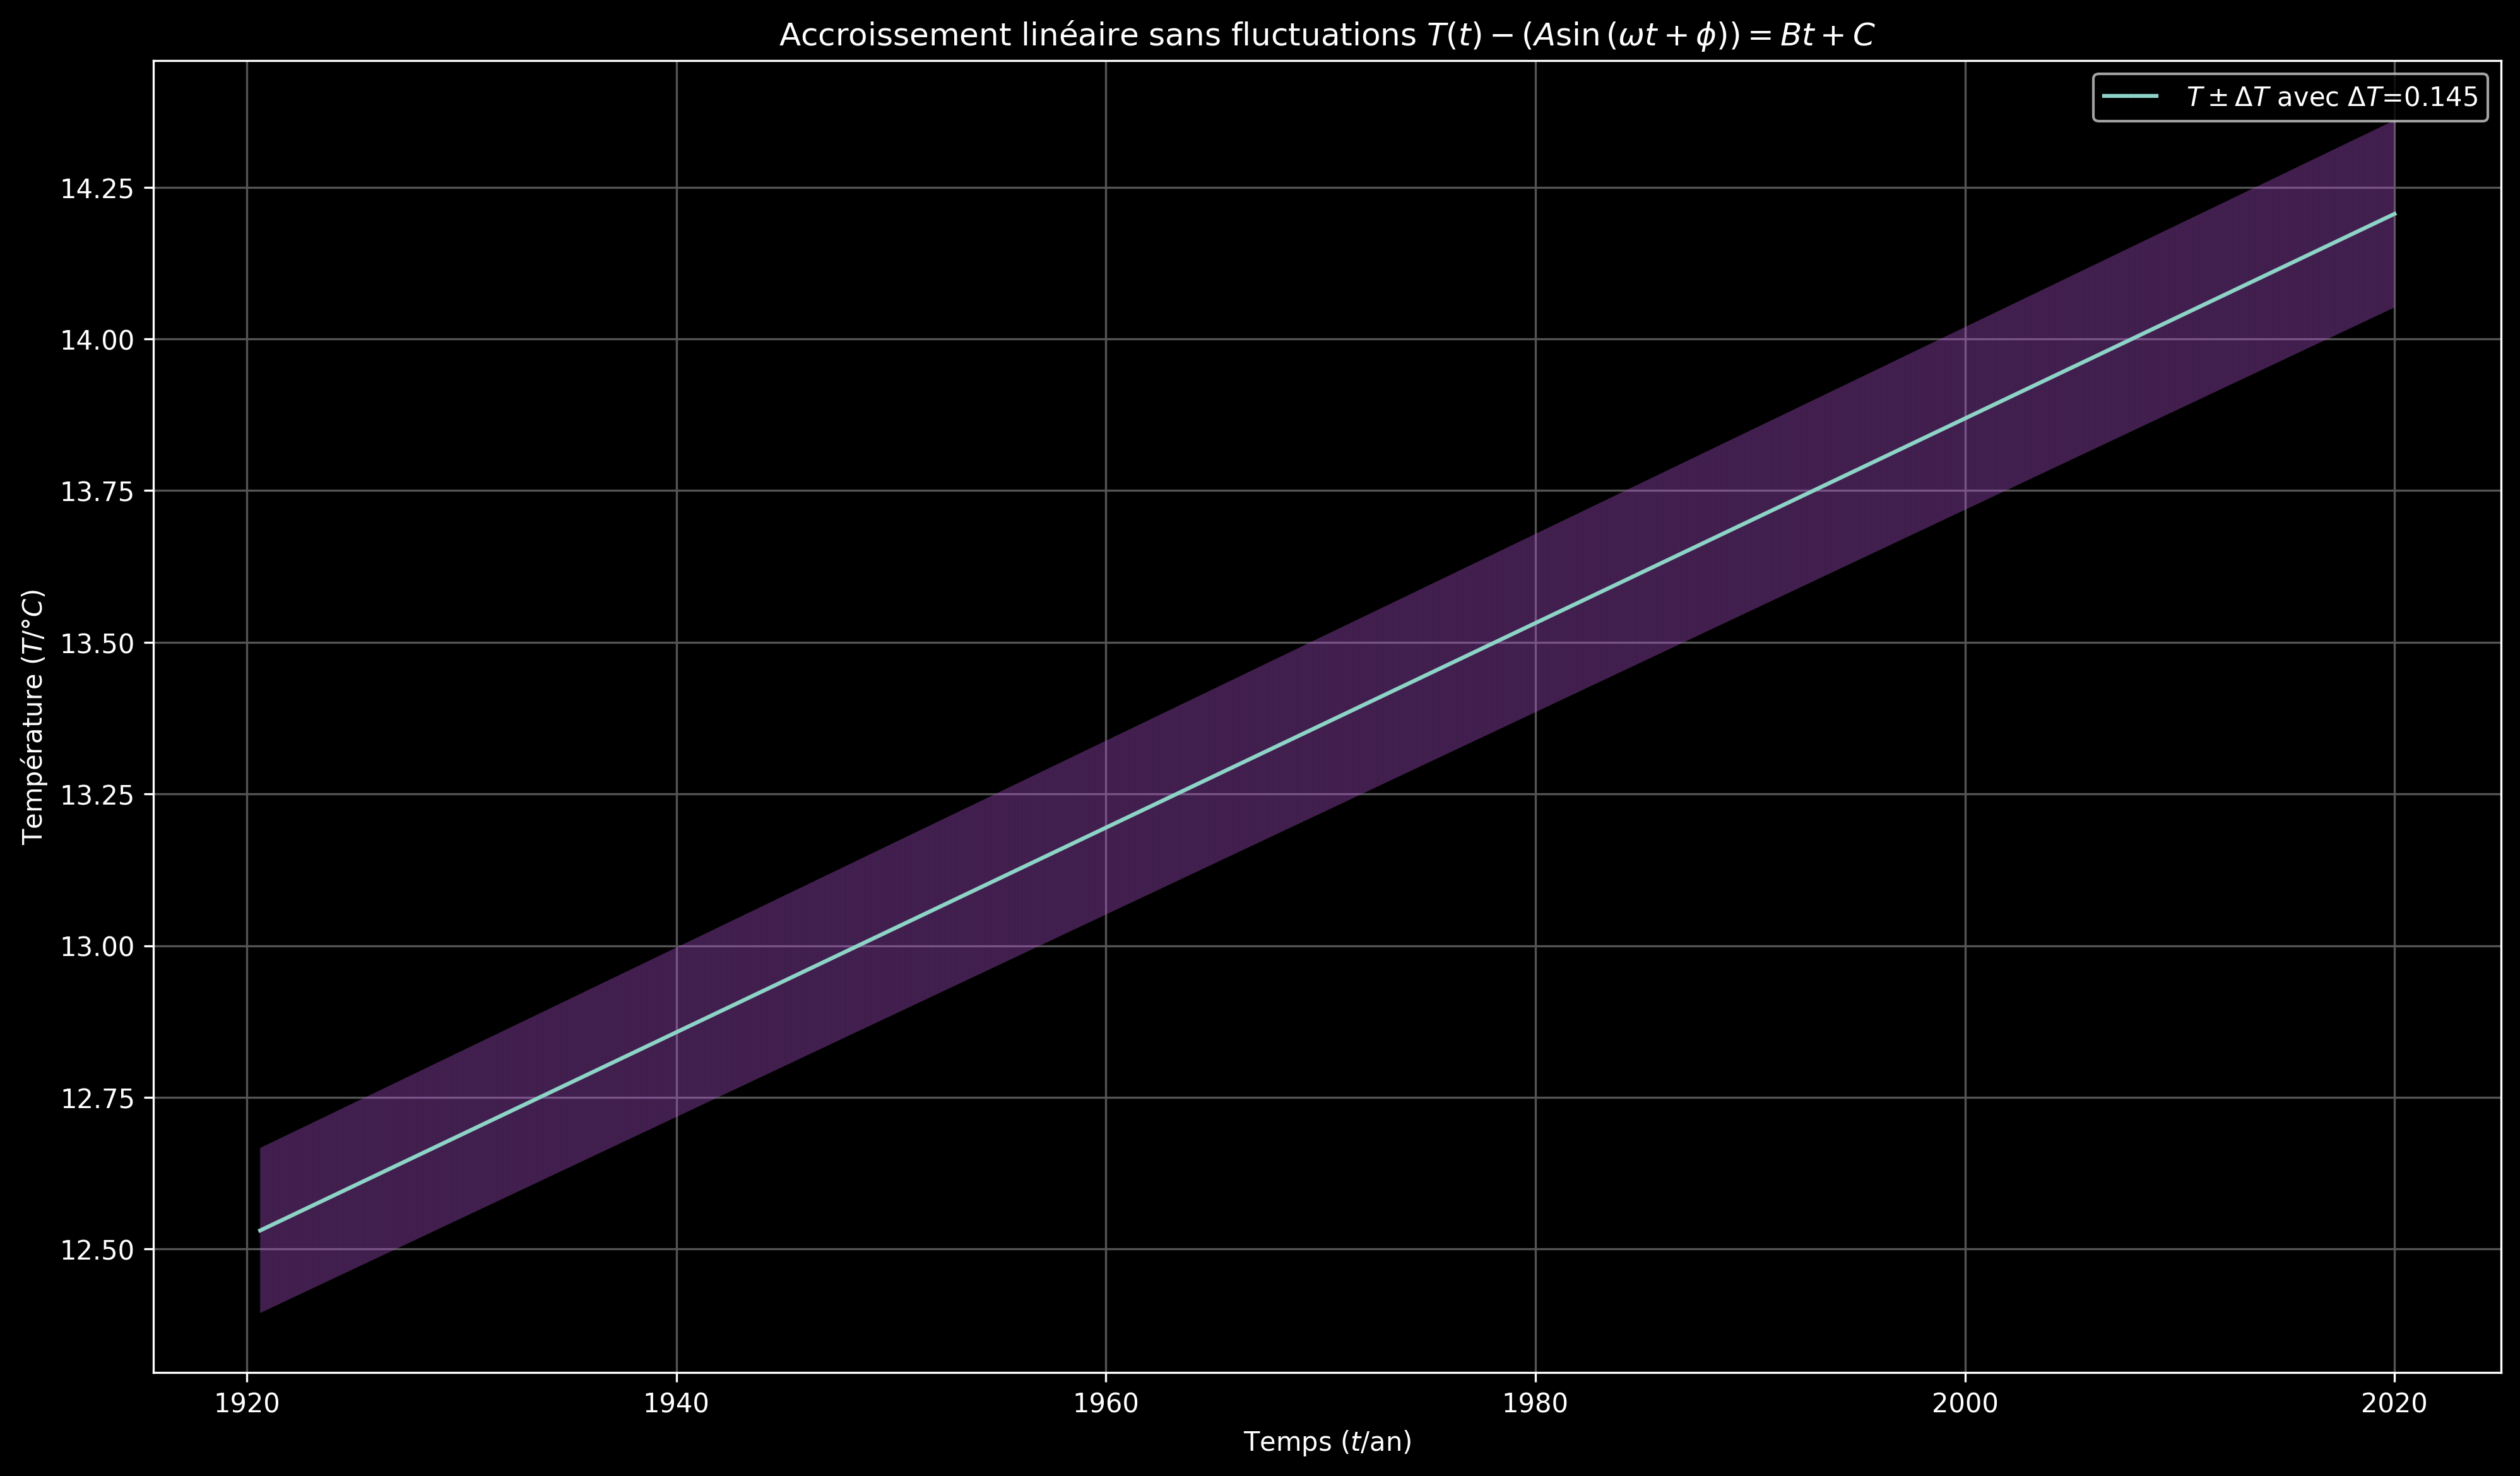

In [5]:
linearincrease = (T(data[0], params[0], params[1], params[2], params[3], params[4]) 
                  - params[0]*np.sin(params[3]*data[0] + params[4]))
yerror = linearincrease*np.sqrt((perr[1]/params[1])**2)

plt.figure(figsize = (16,9), dpi=imsize)
plt.errorbar(dates, linearincrease, yerr=yerror, elinewidth=0.01,  ecolor="#D578FF", 
             label = fr" $ T \pm \Delta T $ avec $ \Delta T $={np.round(np.mean(yerror),3):}")
plt.xlabel(r"Temps ($t$/an)")
plt.ylabel(r"Température ($T$/$\degree C$)")
plt.title(r"Accroissement linéaire sans fluctuations $T(t) - (A \sin{(\omega t + \phi)}) = Bt + C$")
plt.grid(color="#545454")
plt.legend()
plt.show()

On voit ici, comme avec la méthode 1, un effet lent de rechauffement climatique significatif du même ordre $1.5 ^{\circ}C$ mais avec une erreur plus importante ($0.15$ au lieu de $0.09$).

## Conclusion

En conclusion, ce mini-projet a permis de mettre en évidence un effet significatif de réchauffement climatique depuis juin 1920 à Montélimar. Les deux méthodes utilisées, basées sur des ajustements de données selon des fonctions sinusoïdales, ont toutes les deux montré une augmentation linéaire de la température moyenne au fil du temps. La première méthode a montré que les paramètres d'amplitude, de phase et de température moyenne ont varié significativement au cours des décennies, tandis que la deuxième méthode les a maintenus constants et a montré une tendance linéaire globale de l'accroissement de la température moyenne. Dans les deux cas, l'estimation de l'effet de réchauffement climatique est d'environ $1,5 ^{\circ} C$.